# Exploring Slot Machine Data

### 요약
이 노트북의 목적은 [Data_Wrangling.ipynb](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/Data_Wrangling.ipynb)에서 만들어진 데이터의 특징을 탐색하는 것입니다. 데이터를 탐색하고, 이를 토대로 [게임 모델](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/slot.py)을 만들고 [Data_Modeling.ipynb](https://github.com/Jaepal/data-science-portfolio/blob/master/slot_machine/Data_Modeling.ipynb)에서 Multi-armed bandit 알고리즘을 통해 어느 Machine의 RTP가 가장 높은지 알아볼 것입니다.

### 시각화 내용
#### Platinum Slot
1. 각 Symbol의 출현 빈도
2. RICHHITS의 빈도
3. reel의 유형
4. unique한 symbol의 수

In [212]:
# 필요한 패키지 불러오기

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

sns.set(style="darkgrid", font_scale=2)

%matplotlib inline

## Platinum

In [213]:
pl_labels = ['10', 'J', 'Q', 'K', 'A', 'Ca', 'Co', 'D', 'Cr', 'W', 'R']

In [214]:
# csv 파일 불러오기

pl_slot_result = pd.read_csv('../data/slot_machine/platinum_csv/pl_all.csv')
pl_slot_result.head()

,img,classname
0,platinum_0_0.jpg,Ca
1,platinum_0_1.jpg,A
2,platinum_0_2.jpg,Q
3,platinum_0_3.jpg,W
4,platinum_0_4.jpg,A


In [215]:
# 각 칸의 결과마다 game, row, col column 생성

pl_slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(pl_slot_result['img'])]
pl_slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(pl_slot_result['img'])]
pl_slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(pl_slot_result['img'])]

In [216]:
pl_slot_result['game'] = pl_slot_result_game
pl_slot_result['row'] = pl_slot_result_row
pl_slot_result['col'] = pl_slot_result_col

pl_slot_result.head(15)

,img,classname,game,row,col
0,platinum_0_0.jpg,Ca,0,1,1
1,platinum_0_1.jpg,A,0,2,1
2,platinum_0_2.jpg,Q,0,3,1
3,platinum_0_3.jpg,W,0,1,2
4,platinum_0_4.jpg,A,0,2,2
5,platinum_0_5.jpg,A,0,3,2
6,platinum_0_6.jpg,10,0,1,3
7,platinum_0_7.jpg,Cr,0,2,3
8,platinum_0_8.jpg,Co,0,3,3
9,platinum_0_9.jpg,10,0,1,4


In [217]:
tmp = []
pl_slot_result_per_game = []
for n, x in enumerate(pl_slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        pl_slot_result_per_game.append(tmp)
        tmp = []

## 1. 각 Symbol의 출현 빈도 확인

In [218]:
# 각 Symbol의 출현 확률의 구체적인 수치

pl_slot_result['classname'].value_counts() / len(pl_slot_result) * 100

Q     13.236667
10    12.553333
K     12.073333
A     11.506667
J      9.543333
Ca     9.520000
Cr     8.760000
D      8.026667
Co     7.576667
R      4.040000
W      3.163333
Name: classname, dtype: float64

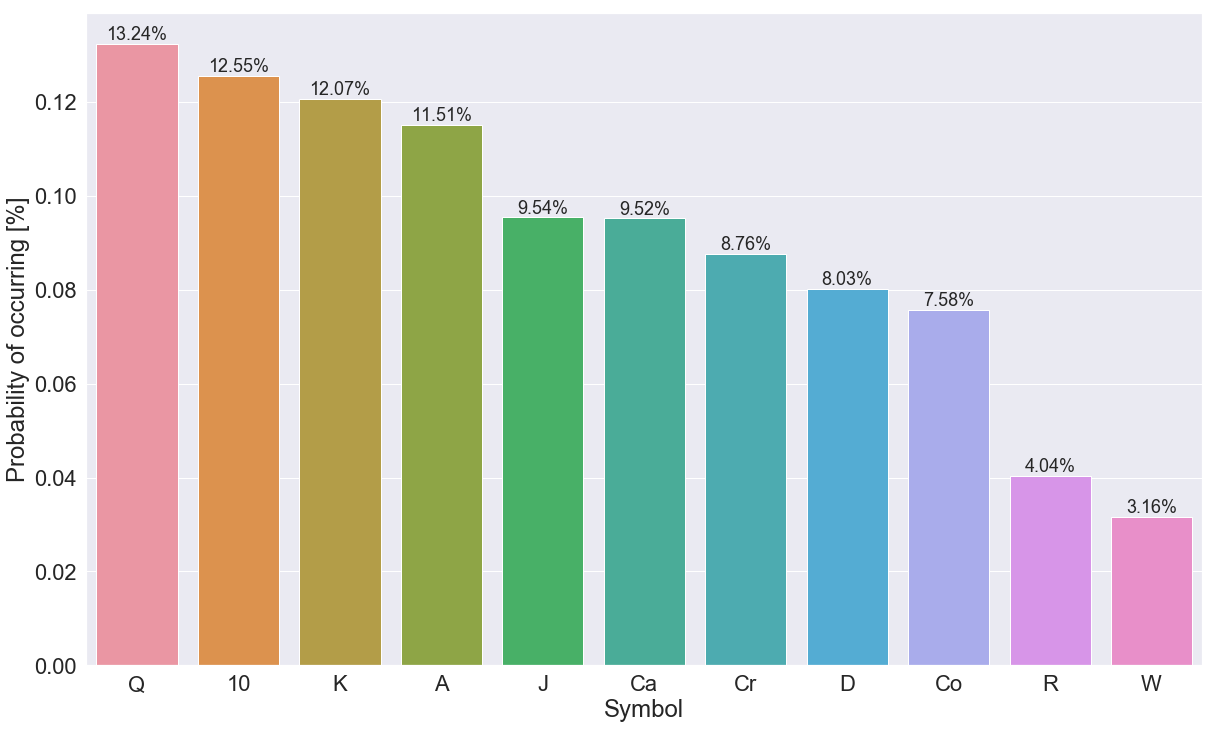

In [219]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=pl_slot_result['classname'].value_counts().index, y=pl_slot_result['classname'].value_counts() / len(pl_slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

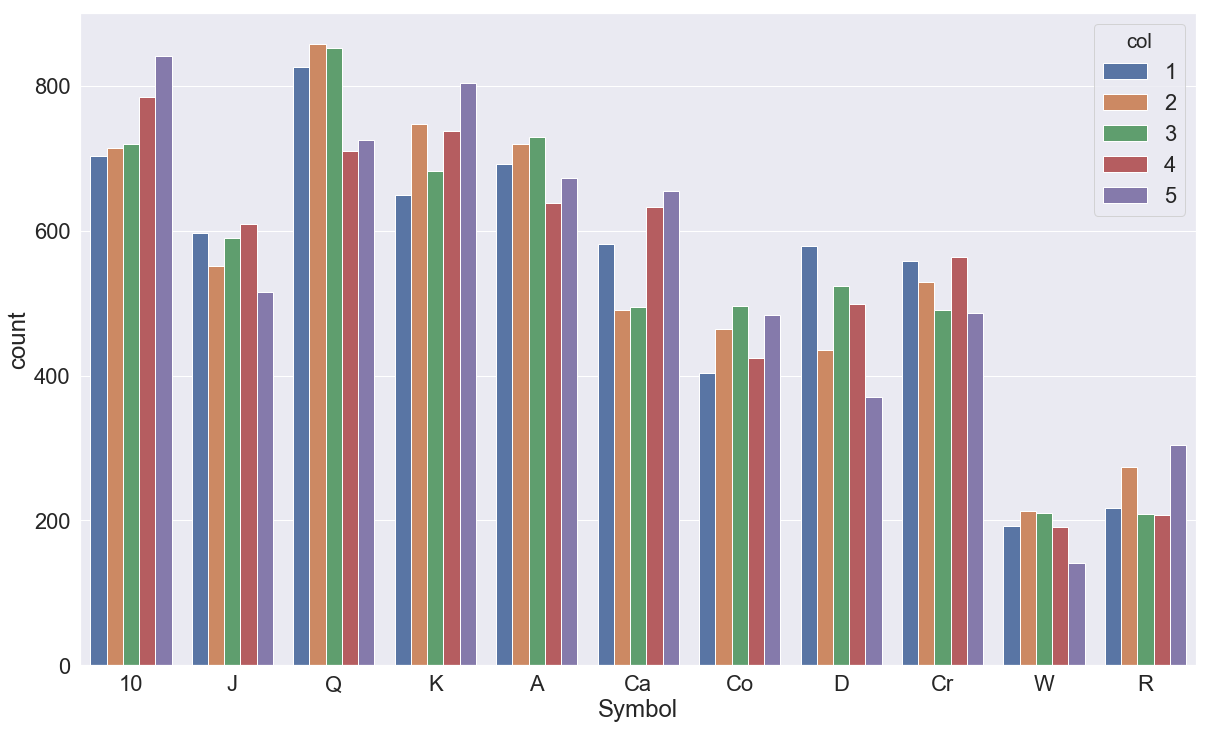

In [221]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=pl_slot_result, hue='col', order=pl_labels)
plt.xlabel("Symbol")
plt.show()

## 2. Simulation 데이터 생성
각 15개의 칸이 위의 각 Symbol의 출현 확률을 가지고 완전히 독립적으로 작동한다는 가정 하에 2000번의 Simulation 데이터를 생성하고, 게임 모델을 보완하여 최대한 실제 게임과 가깝게 만들기 위해 실제 게임과의 차이를 확인합니다.

In [223]:
'''
# Baseline Model

2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정

# Q   : 13.5 %
# 10  : 12.5 %
# K   : 12 %
# A   : 11.5 %
# J   : 9.5 %
# Ca  : 9.5 %
# Cr  : 9 %
# D   : 8 %
# Co  : 7.5 %
# R   : 4 %
# W   : 3 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getPlatinumSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'Q'
    elif i <= 52 and i > 27:
        return '10'
    elif i <= 76 and i > 52:
        return 'K'
    elif i <= 99 and i > 76:
        return 'A'
    elif i <= 118 and i > 99:
        return 'J'
    elif i <= 137 and i > 118:
        return 'Ca'
    elif i <= 155 and i > 137:
        return 'Cr'
    elif i <= 171 and i > 155:
        return 'D'
    elif i <= 186 and i > 171:
        return 'Co'
    elif i <= 192 and i > 186:
        return 'W'
    elif i > 192:
        return 'R'

# 1회의 Spin 실행을 구현한 함수

def spin_platinum():
    game = []
    start = 1
    end = 201
    for i in range(15):
        if game.count('R') >= 9:
            end = 193
        game.append(getPlatinumSymbol(start, end))
    return game

# 플레이 횟수, 배팅 금액을 받아와서 게임을 플레이
def playPlatinum(n, bet):
    bpl = bet / 30
    pay_list = []
    while(n):
        game = spin_platinum()
        pay_list.append(calPlatinumPayline(game, bpl))
        n -= 1
    return pay_list

In [272]:
'''
# ColType 개량 버전
'''


def getPlatinumColType(i):
    if i==0:
        j = np.random.randint(1, 201)
        if j <= 109:
            return '3'
        elif j <= 151 and j > 109:
            return '2-1'
        elif j <= 169 and j > 151:
            return '2-2'
        elif j <= 186 and j > 169:
            return '2-3'
        elif j > 186:
            return '1'
    if i==1:
        j = np.random.randint(1, 201)
        if j <= 88:
            return '3'
        elif j <= 127 and j > 88:
            return '2-1'
        elif j <= 138 and j > 127:
            return '2-2'
        elif j <= 183 and j > 138:
            return '2-3'
        elif j > 183:
            return '1'
    if i==2:
        j = np.random.randint(1, 201)
        if j <= 93:
            return '3'
        elif j <= 125 and j > 93:
            return '2-1'
        elif j <= 137 and j > 125:
            return '2-2'
        elif j <= 176 and j > 137:
            return '2-3'
        elif j > 176:
            return '1'
    if i==3:
        j = np.random.randint(1, 201)
        if j <= 110:
            return '3'
        elif j <= 130 and j > 110:
            return '2-1'
        elif j <= 149 and j > 130:
            return '2-2'
        elif j <= 192 and j > 149:
            return '2-3'
        elif j > 192:
            return '1'
    if i==4:
        j = np.random.randint(1, 201)
        if j <= 78:
            return '3'
        elif j <= 127 and j > 78:
            return '2-1'
        elif j <= 134 and j > 127:
            return '2-2'
        elif j <= 151 and j > 134:
            return '2-3'
        elif j > 151:
            return '1'

def getPlatinumSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 27:
        return 'Q'
    elif i <= 52 and i > 27:
        return '10'
    elif i <= 76 and i > 52:
        return 'K'
    elif i <= 99 and i > 76:
        return 'A'
    elif i <= 118 and i > 99:
        return 'J'
    elif i <= 137 and i > 118:
        return 'Ca'
    elif i <= 155 and i > 137:
        return 'Cr'
    elif i <= 171 and i > 155:
        return 'D'
    elif i <= 186 and i > 171:
        return 'Co'
    elif i <= 192 and i > 186:
        return 'W'
    elif i > 192:
        return 'R'

def spin_platinum():
    game = []
    start = 1
    end = 201
    for i in range(5):
        tmp = []
        if game.count('R') >= 9:
            end = 193
        col_type = getPlatinumColType(i)
        if col_type == '3':
            for i in range(3):
                tmp.append(getPlatinumSymbol(start, end))
        elif col_type == '2-1':
            tmp.extend([getPlatinumSymbol(start, end)]*2)
            tmp.append(getPlatinumSymbol(start, end))
        elif col_type == '2-2':
            tmp.extend([getPlatinumSymbol(start, end)]*2)
            tmp.append(getPlatinumSymbol(start, end))
            tmp[2], tmp[1] = tmp[1], tmp[2]
        elif col_type == '2-3':
            tmp.append(getPlatinumSymbol(start, end))
            tmp.extend([getPlatinumSymbol(start, end)]*2)
        elif col_type == '1':
            tmp.extend([getPlatinumSymbol(start, end)]*3)
        game.extend(tmp)
    return game

In [576]:
'''
# 확률 가중치 개량 버전
'''


def getPlatinumColType(i):
    if i==0:
        j = np.random.randint(1, 201)
        if j <= 109:
            return '3'
        elif j <= 151 and j > 109:
            return '2-1'
        elif j <= 169 and j > 151:
            return '2-2'
        elif j <= 186 and j > 169:
            return '2-3'
        elif j > 186:
            return '1'
    if i==1:
        j = np.random.randint(1, 201)
        if j <= 88:
            return '3'
        elif j <= 127 and j > 88:
            return '2-1'
        elif j <= 138 and j > 127:
            return '2-2'
        elif j <= 183 and j > 138:
            return '2-3'
        elif j > 183:
            return '1'
    if i==2:
        j = np.random.randint(1, 201)
        if j <= 93:
            return '3'
        elif j <= 125 and j > 93:
            return '2-1'
        elif j <= 137 and j > 125:
            return '2-2'
        elif j <= 176 and j > 137:
            return '2-3'
        elif j > 176:
            return '1'
    if i==3:
        j = np.random.randint(1, 201)
        if j <= 110:
            return '3'
        elif j <= 130 and j > 110:
            return '2-1'
        elif j <= 149 and j > 130:
            return '2-2'
        elif j <= 192 and j > 149:
            return '2-3'
        elif j > 192:
            return '1'
    if i==4:
        j = np.random.randint(1, 201)
        if j <= 78:
            return '3'
        elif j <= 127 and j > 78:
            return '2-1'
        elif j <= 134 and j > 127:
            return '2-2'
        elif j <= 151 and j > 134:
            return '2-3'
        elif j > 151:
            return '1'

def getPlatinumSymbol(probs, r_full=0):
    if r_full:
        i = np.random.randint(1, sum(probs[:10])+1)
    else:
        i = np.random.randint(1, sum(probs)+1)
    if i <= sum(probs[:1]):
        return 'Q'
    elif i <= sum(probs[:2]) and i > sum(probs[:1]):
        return '10'
    elif i <= sum(probs[:3]) and i > sum(probs[:2]):
        return 'K'
    elif i <= sum(probs[:4]) and i > sum(probs[:3]):
        return 'A'
    elif i <= sum(probs[:5]) and i > sum(probs[:4]):
        return 'J'
    elif i <= sum(probs[:6]) and i > sum(probs[:5]):
        return 'Ca'
    elif i <= sum(probs[:7]) and i > sum(probs[:6]):
        return 'Cr'
    elif i <= sum(probs[:8]) and i > sum(probs[:7]):
        return 'D'
    elif i <= sum(probs[:9]) and i > sum(probs[:8]):
        return 'Co'
    elif i <= sum(probs[:10]) and i > sum(probs[:9]):
        return 'W'
    elif i > sum(probs[:10]):
        return 'R'

def getWeightedProbability(game):
    weight = [27, 25, 24, 23, 19, 19, 18, 16, 15, 8, 6]
    switch = [0] * 11
    unique_list = list(set(game))
    for n, s in enumerate(labels):
        if s in unique_list:
            switch[n] = 2
        if s != 'R' and game.count(s) >= 6:
            switch[n] = 5
    probs = [w*(switch[n]+1) for n, w in enumerate(weight)]
    return probs

def spin_platinum():
    game = []
    r_full = 0
    for i in range(5):
        probs = getWeightedProbability(game)
        tmp = []
        if game.count('R') >= 9:
            r_full = 1
        col_type = getPlatinumColType(i)
        if col_type == '3':
            for i in range(3):
                tmp.append(getPlatinumSymbol(probs, r_full))
        elif col_type == '2-1':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
            tmp.append(getPlatinumSymbol(probs, r_full))
        elif col_type == '2-2':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
            tmp.append(getPlatinumSymbol(probs, r_full))
            tmp[2], tmp[1] = tmp[1], tmp[2]
        elif col_type == '2-3':
            tmp.append(getPlatinumSymbol(probs, r_full))
            tmp.extend([getPlatinumSymbol(probs, r_full)]*2)
        elif col_type == '1':
            tmp.extend([getPlatinumSymbol(probs, r_full)]*3)
        game.extend(tmp)
    return game

In [224]:
# 실행 결과를 담을 list
pl_simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    pl_simul_result_per_game.append(spin_platinum())

In [225]:
# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

pl_simul_result = pl_slot_result[['classname', 'game', 'row', 'col']]

pl_simul_classname = []

for game in pl_simul_result_per_game:
    for x in game:
        pl_simul_classname.append(x)

pl_simul_result['classname'] = pl_simul_classname

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [227]:
pl_simul_result.head()

,classname,game,row,col
0,D,0,1,1
1,Cr,0,2,1
2,K,0,3,1
3,Q,0,1,2
4,R,0,2,2


## 3-1. 비교 - RICHHITS

In [231]:
# 실제 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

pl_real_rich_count = []
for game in pl_slot_result_per_game:
    pl_real_rich_count.append(game.count('R'))

# 실제 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(pl_real_rich_count).value_counts()

0    1242
1     434
2     223
3      77
4      19
5       5
dtype: int64

In [232]:
# 가상 게임의 게임당 RICHHITS 출현 횟수를 담은 list를 생성

pl_simul_rich_count = []
for game in pl_simul_result_per_game:
    pl_simul_rich_count.append(game.count('R'))

# 가상 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(pl_simul_rich_count).value_counts()

0    1117
1     646
2     198
3      33
4       6
dtype: int64

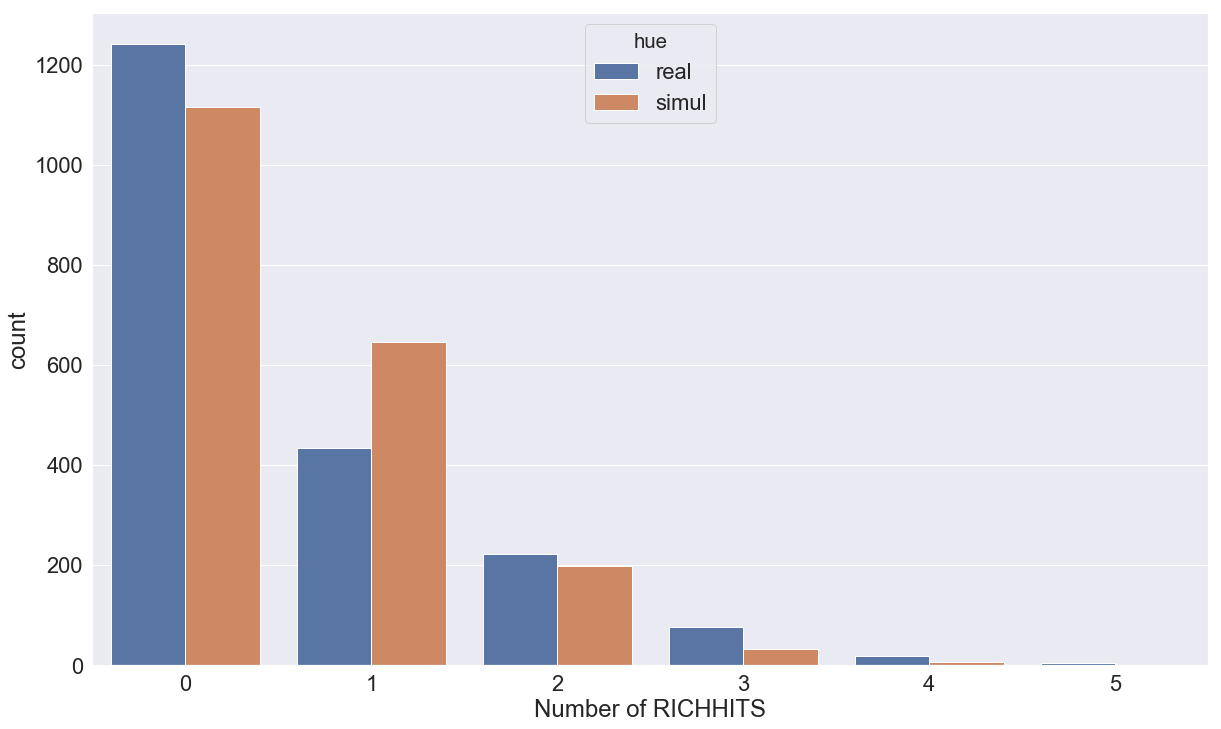

In [233]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

pl_df_rich = pd.DataFrame(columns=['rich_count', 'hue'])
pl_df_rich['rich_count'] = pl_real_rich_count + pl_simul_rich_count
pl_df_rich['hue'] = ['real'] * 2000 + ['simul'] * 2000

# 실제, 가상의 각 게임당 RICHHITS 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='rich_count', data=pl_df_rich, hue='hue')
plt.xlabel("Number of RICHHITS")
plt.show()

시각화 결과 시뮬레이션 데이터와 실제 데이터 사이에 어느정도 차이가 있는 것처럼 보인다는 것을 알 수 있습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다. 카이제곱 적합도 검정은 범주형 확률분포의 모수 $\mu=(\mu_1, \ldots, \mu_K)$에 대한 가설을 조사하는 검정 방법입니다. 원래 범주형 값 $k$가 나와야 할 횟수의 기댓값 $m_k$와 실제 나온 횟수 $x_k$의 차이를 이용하여 다음처럼 검정통계량을 구합니다.

$$
\begin{align}
\sum_{k=1}^K \dfrac{(x_k - m_k)^2}{m_k}
\end{align}
$$

###### Hypothesis test 1

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [235]:
length = min(len(pd.Series(pl_real_rich_count).value_counts()), len(pd.Series(pl_simul_rich_count).value_counts()))

f_obs = list(pd.Series(pl_real_rich_count).value_counts())[:length]
f_exp = list(pd.Series(pl_simul_rich_count).value_counts())[:length]

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=173.55101609093532, pvalue=1.8082107354554408e-36)

p-value가 1.3912538539206486e-32로 유의수준 0.05보다 매우 작은 값이므로 기무가설을 기각하고 대립가설을 지지합니다.

---

## 3-2. 비교 - 각 reel 마다 같은 symbol이 나오는 빈도 비교

각 reel은 3개의 칸으로 구성되어 있기 때문에  

1번 유형   | ●●● (모두 같음)  
2-1번 유형 | ●●○ (3번째만 다르고 나머지는 같음)  
2-2번 유형 | ●○● (2번째만 다르고 나머지는 같음)  
2-3번 유형 | ○●● (1번째만 다르고 나머지는 같음)  
3번 유형   | ●○⊙ (모두 다름)

다음과 같이 symbol이 겹치는 수에 따라 5개의 유형으로 구분지을 수 있습니다.

In [236]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [240]:
# 실제 게임의 각 reel의 유형, symbol 저장

pl_real_reel1_rtype, pl_real_reel1_rsymbols = getReelInfo(pl_slot_result, 1)
pl_real_reel2_rtype, pl_real_reel2_rsymbols = getReelInfo(pl_slot_result, 2)
pl_real_reel3_rtype, pl_real_reel3_rsymbols = getReelInfo(pl_slot_result, 3)
pl_real_reel4_rtype, pl_real_reel4_rsymbols = getReelInfo(pl_slot_result, 4)
pl_real_reel5_rtype, pl_real_reel5_rsymbols = getReelInfo(pl_slot_result, 5)

pl_real_reel_rtype = pl_real_reel1_rtype + pl_real_reel2_rtype + pl_real_reel3_rtype+ pl_real_reel4_rtype + pl_real_reel5_rtype 

In [241]:
# 가상 게임의 각 reel의 유형, symbol 저장

pl_simul_reel1_rtype, pl_simul_reel1_rsymbols = getReelInfo(pl_simul_result, 1)
pl_simul_reel2_rtype, pl_simul_reel2_rsymbols = getReelInfo(pl_simul_result, 2)
pl_simul_reel3_rtype, pl_simul_reel3_rsymbols = getReelInfo(pl_simul_result, 3)
pl_simul_reel4_rtype, pl_simul_reel4_rsymbols = getReelInfo(pl_simul_result, 4)
pl_simul_reel5_rtype, pl_simul_reel5_rsymbols = getReelInfo(pl_simul_result, 5)

pl_simul_reel_rtype = pl_simul_reel1_rtype + pl_simul_reel2_rtype + pl_simul_reel3_rtype + pl_simul_reel4_rtype + pl_simul_reel5_rtype

In [242]:
# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_pl_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_pl_rtype['reel_type'] = pl_real_reel_rtype + pl_simul_reel_rtype
df_pl_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_pl_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

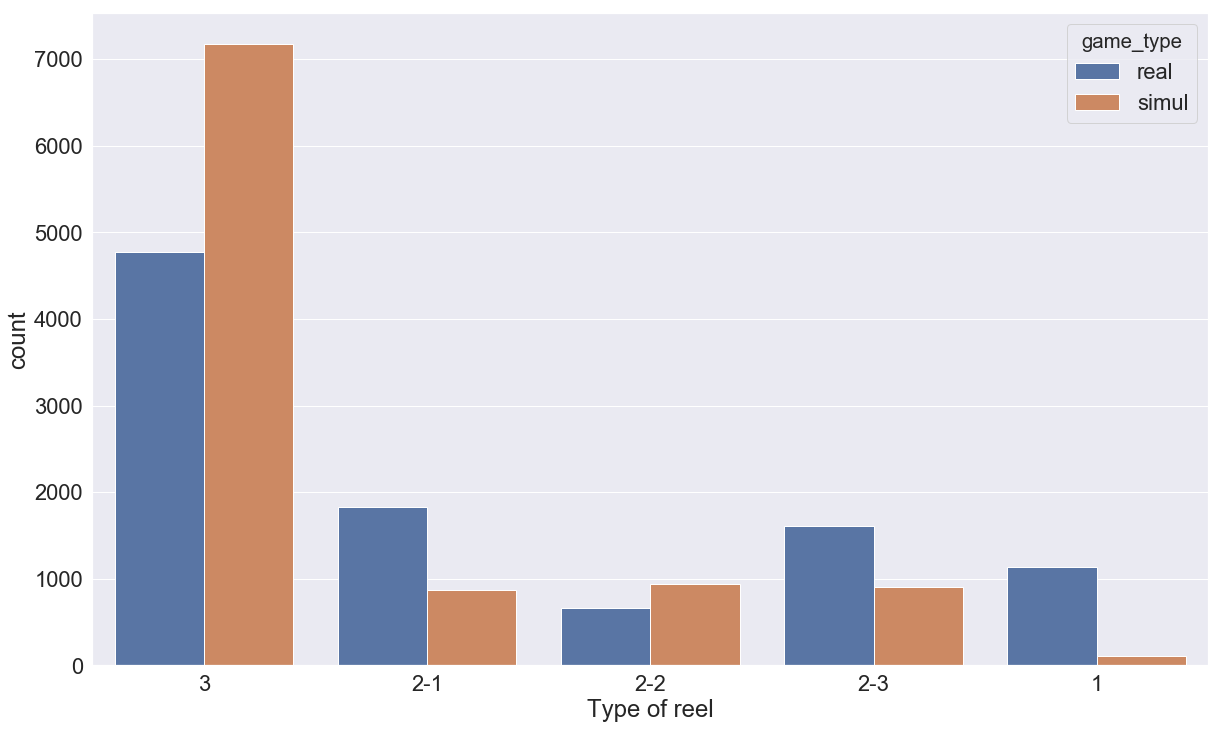

In [243]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_pl_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

시각화 결과 시뮬레이션 결과와 실제 결과 사이에 큰 차이가 있음을 알 수 있습니다. 시뮬레이션의 모델처럼 모든 칸이 독립적이고 설정된 확률대로 Symbol이 등장하게 되면 한 개의 reel에서 3개가 모두 다를 확률(reel_type == 3)은 크고 (약 70%) 모두 같을 확률(reel_type == 1)은 매우 적지만 (약 1%) 실제 게임 결과에서는 3개가 모두 다를 확률은 시뮬레이션 결과보다 더 작고 모두 같을 확률은 훨씬 큰 것으로 나타납니다.

또한 2개가 같고 1개는 다른 유형에서도 다른 symbol의 위치에 따라 확률이 서로 다른 것을 확인할 수 있습니다.

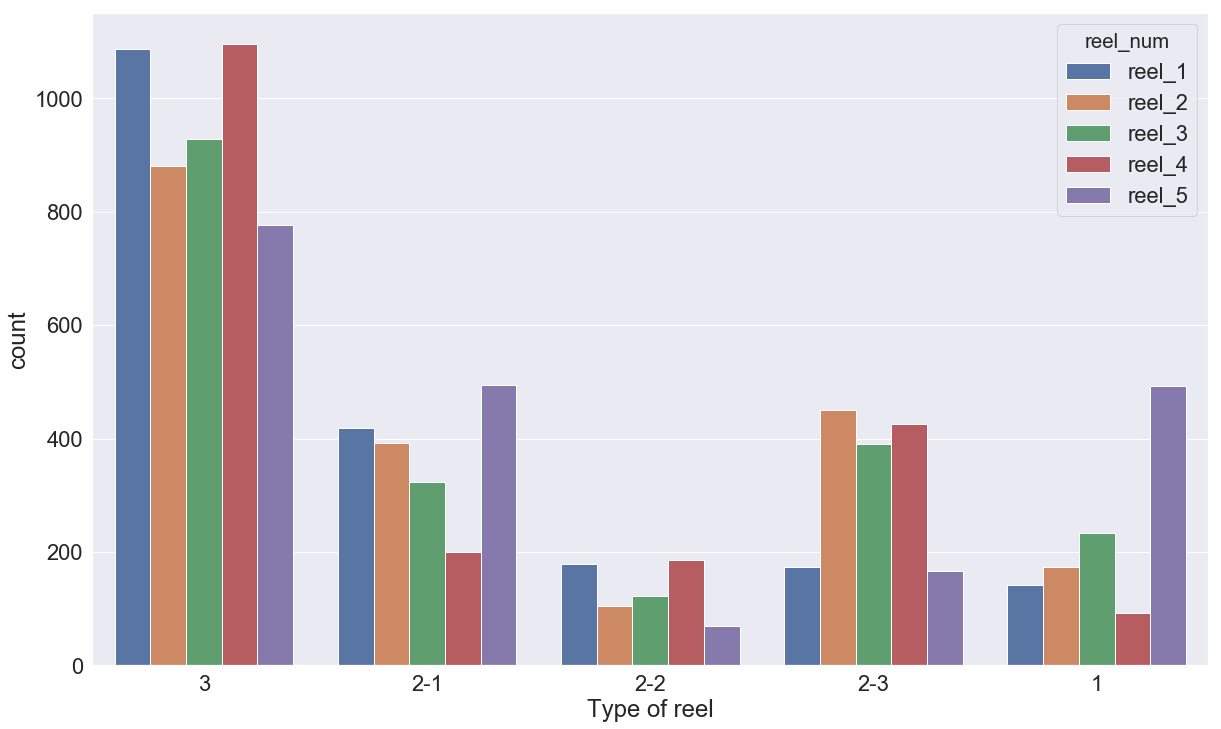

In [244]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_pl_rtype[df_pl_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

5개의 reel 별로 시각화를 한 결과 reel에 따라서도 각 유형의 확률이 다른 것을 알 수 있습니다.

따라서 게임의 모델을 보완할 때 각 reel_type의 출현 확률, 각 reel별 확률을 고려할 필요가 있음을 알 수 있습니다.

---

## 3.3 비교 - 한 번의 spin마다 등장하는 symbol의 개수 비교

In [245]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

pl_real_unique_count = []

for i in range(2000):
    pl_real_unique_count.append(len(set(pl_slot_result_per_game[i])))

In [246]:
# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

pl_simul_unique_count = []

for i in range(2000):
    pl_simul_unique_count.append(len(set(pl_simul_result_per_game[i])))

In [247]:
df_pl_real_simul = pd.DataFrame(columns=['classname', 'game_type'])
df_pl_real_simul['classname'] = pd.concat([pl_slot_result['classname'], pl_simul_result['classname']])
df_pl_real_simul['game_type'] = ['real'] * len(pl_slot_result['classname']) + ['simul'] * len(pl_simul_result['classname'])
df_pl_real_simul = df_pl_real_simul.reset_index(drop=True)

In [248]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_pl_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_pl_unique_count['unique_count'] = pl_real_unique_count + pl_simul_unique_count
df_pl_unique_count['game_type'] = ['real'] * len(pl_real_unique_count) + ['simul'] * len(pl_simul_unique_count)

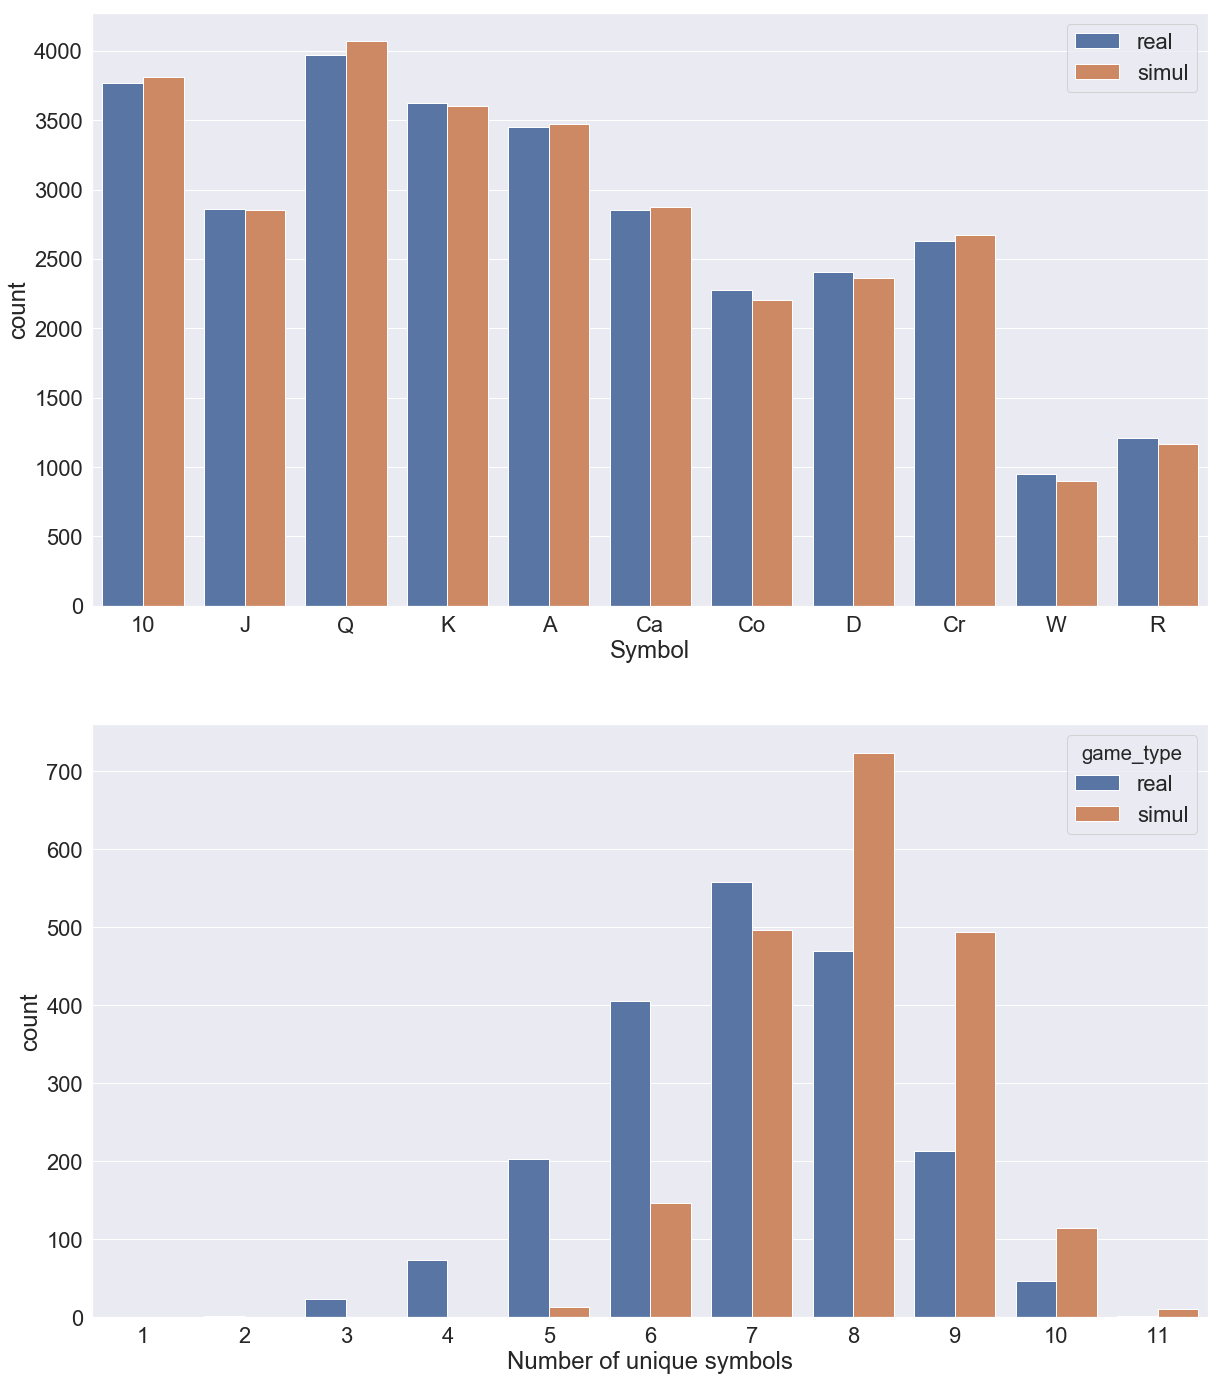

In [250]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=df_pl_real_simul, hue='game_type', order=pl_labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_pl_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()

우선 각 게임의 고유한 Symbol 개수를 알아보기 전에, 실제 게임 데이터의 Symbol별 등장 확률과 가상 게임 데이터의 등장 확률이 같은 지를 확인해보겠습니다. 이 차이가 유의한지 여부를 확인하기 위해 카이제곱 적합도 검정을 사용합니다.

###### Hypothesis test 3

귀무 가설과 대립 가설은 아래와 같습니다.

* H<sub>0</sub>: 시뮬레이션 결과는 실제 결과와 같다
* H<sub>1</sub>: 시뮬레이션 결과는 실제 결과와 다르다

테스트는 5% 유의 수준에서 수행되었습니다.

In [252]:
f_obs = list(pl_slot_result['classname'].value_counts().sort_index())
f_exp = list(pl_simul_result['classname'].value_counts().sort_index())

st.chisquare(f_obs, f_exp=f_exp)

Power_divergenceResult(statistic=11.876820605183237, pvalue=0.2933850571708448)

p-value가 ??로 유의수준 0.05보다 큰 값이므로 귀무가설을 지지합니다. 이처럼 실제 결과와 시뮬레이션 결과의 Symbol 등장 횟수는 차이가 없다고 볼 수 있지만 두번째 시각화 그래프를 보면 가상 게임 데이터는 실제 게임 데이터에 비해 오른쪽으로 치우쳐있는 것을 볼 수 있습니다.
즉 위의 2개의 그래프는 실제 게임에서는 시뮬레이션 게임에 비에서 Symbol이 같은 것끼리 몰아서 나오는 경향을 가지고 있다는 것을 의미합니다.

---

## 3-4 비교 - 획득한 reward 금액과 payline의 길이(x3, x4, x5) 비교

In [301]:
payTable = pd.read_csv('../data/slot_machine/platinum_csv/payTable.csv')
paylines = [[1, 4, 7, 10, 13],
             [0, 3, 6, 9, 12],
             [2, 5, 8, 11, 14],
             [0, 4, 8, 10, 12],
             [2, 4, 6, 10, 14],
             [0, 3, 7, 11, 14],
             [2, 5, 7, 9, 12],
             [1, 5, 8, 11, 13],
             [1, 3, 6, 9, 13],
             [0, 4, 7, 10, 12],
             [2, 4, 7, 10, 14],
             [0, 4, 6, 10, 12],
             [2, 4, 8, 10, 14],
             [1, 4, 6, 10, 13],
             [1, 4, 8, 10, 13],
             [1, 5, 7, 9, 13],
             [1, 3, 7, 11, 13],
             [0, 5, 6, 11, 12],
             [2, 3, 8, 9, 14],
             [1, 3, 8, 9, 13],
             [1, 5, 6, 11, 13],
             [0, 3, 8, 9, 12],
             [2, 5, 6, 11, 14],
             [0, 5, 8, 11, 12],
             [2, 3, 6, 9, 14],
             [0, 3, 7, 9, 12],
             [2, 5, 7, 11, 14],
             [0, 4, 8, 11, 14],
             [2, 4, 6, 9, 12],
             [1, 3, 7, 9, 13]]

def getSym(lst):
    if len(set(lst)) < 2:
        return lst[0]
    else:
        for x in list(set(lst)):
            if x != 'W':
                return x
            else:
                continue

def richCheck(game, bpl):
    rnum = game.count('R')
    if rnum <= 2:
        return 0
    elif rnum == 3:
        return bpl * 30
    elif rnum == 4:
        return bpl * 90
    elif rnum == 5:
        return bpl * 240
    elif rnum == 6:
        return bpl * 900
    elif rnum == 7:
        return bpl * 2250
    elif rnum == 8:
        return bpl * 15000
    elif rnum == 9:
        return bpl * 30000

def calPlatinumPayline(game, bpl):
    pay = 0
    r_acc = 0
    pay_type_list = []
    
    # RICH 보너스 계산
    pay += richCheck(game, bpl)
    r_acc += game.count('R')
    
    # payline 계산
    for n, payline in enumerate(paylines):
        tmp = []
        for i in range(5):
            if i == 4:
                tmp.append(game[payline[i]])
                break
            if i == 0 and game[payline[i]] == 'W':
                tmp.append(game[payline[i]])
            elif game[payline[i]] != game[payline[i+1]] and game[payline[i+1]] != 'W':
                tmp.append(game[payline[i]])
                break
            else:
                tmp.append(game[payline[i]])

        if len(tmp) >= 3:
            print('payline {} symbol'.format(n), tmp)
            sym = getSym(tmp)
            pay += payTable.loc[len(tmp)-3, sym] * bpl
            pay_type_list.append(tmp)
    return pay, pay_type_list

In [302]:
pl_real_pay_list, pl_real_pay_type_list = [], []
n = 1
for real_game in pl_slot_result_per_game[:10]:
    print('game', n)
    #pl_real_pay_list.append(calPlatinumPayline(real_game, 2000)[0])
    pl_real_pay_type_list.extend(calPlatinumPayline(real_game, 2000)[1])
    n += 1

game 1
game 2
game 3
game 4
game 5
game 6
game 7
payline 8 symbol ['K', 'K', 'K']
payline 13 symbol ['K', 'K', 'K']
payline 20 symbol ['K', 'K', 'K']
game 8
game 9
game 10


In [300]:
pl_real_pay_type_list[:10]

[['K', 'K', 'K'], ['K', 'K', 'K'], ['K', 'K', 'K']]

In [210]:
print('Simulation Average Reward : ', sum(simul_pay_list) / len(simul_pay_list))
print('Real Average Reward : ', sum(real_pay_list) / len(real_pay_list))

NameError: name 'simul_pay_list' is not defined

# Monster

In [126]:
# csv 파일 불러오기

ms_slot_result = pd.read_csv('../data/slot_machine/monster_csv/ms_all.csv')
ms_slot_result.head()

,img,classname
0,monster_0_0.jpg,OM
1,monster_0_1.jpg,W
2,monster_0_2.jpg,A
3,monster_0_3.jpg,A
4,monster_0_4.jpg,Q


In [127]:
len(ms_slot_result)

30000

In [128]:
ms_labels = ['10', 'J', 'Q', 'K', 'A', 'GGM', 'OM', 'RM', 'GWM', 'W', 'S']

In [129]:
# 각 칸의 결과마다 game, row, col column 생성

ms_slot_result_game = [int(i_name.split('_')[1]) for n, i_name in enumerate(ms_slot_result['img'])]
ms_slot_result_row = [int(i_name.split('_')[2].split('.')[0]) % 3 + 1 for n, i_name in enumerate(ms_slot_result['img'])]
ms_slot_result_col = [int(i_name.split('_')[2].split('.')[0]) // 3 + 1 for n, i_name in enumerate(ms_slot_result['img'])]

In [130]:
ms_slot_result['game'] = ms_slot_result_game
ms_slot_result['row'] = ms_slot_result_row
ms_slot_result['col'] = ms_slot_result_col

ms_slot_result.head(15)

,img,classname,game,row,col
0,monster_0_0.jpg,OM,0,1,1
1,monster_0_1.jpg,W,0,2,1
2,monster_0_2.jpg,A,0,3,1
3,monster_0_3.jpg,A,0,1,2
4,monster_0_4.jpg,Q,0,2,2
5,monster_0_5.jpg,GWM,0,3,2
6,monster_0_6.jpg,OM,0,1,3
7,monster_0_7.jpg,10,0,2,3
8,monster_0_8.jpg,J,0,3,3
9,monster_0_9.jpg,GGM,0,1,4


In [131]:
tmp = []
ms_slot_result_per_game = []
for n, x in enumerate(ms_slot_result['classname']):
    tmp.append(x)
    if (n+1) % 15 == 0:
        ms_slot_result_per_game.append(tmp)
        tmp = []

In [132]:
# 각 Symbol의 출현 확률의 구체적인 수치

ms_slot_result['classname'].value_counts() / len(ms_slot_result) * 100

Q      14.126667
K      13.960000
10     13.136667
A      12.740000
J      12.003333
GGM     9.553333
OM      7.376667
RM      6.440000
S       4.786667
GWM     4.393333
W       1.483333
Name: classname, dtype: float64

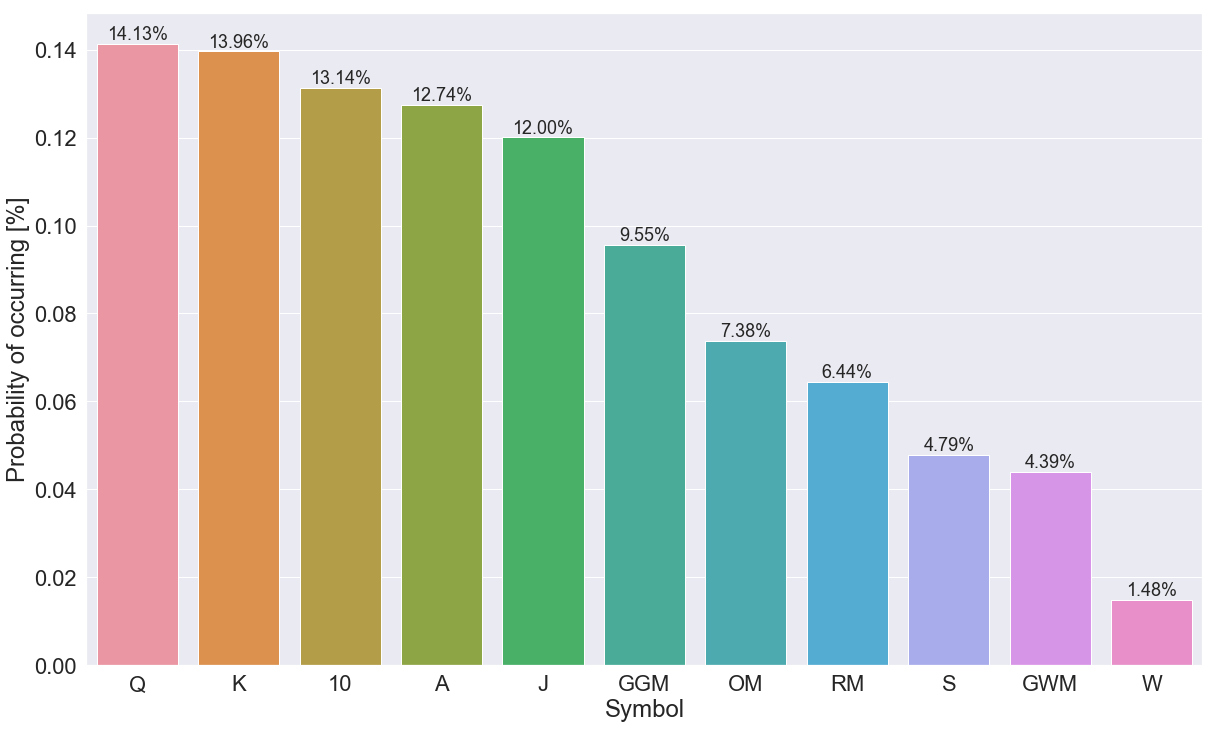

In [133]:
# 각 Symbol의 출현 확률 시각화

plt.figure(figsize=(20,12))
ax = sns.barplot(x=ms_slot_result['classname'].value_counts().index, y=ms_slot_result['classname'].value_counts() / len(ms_slot_result))
plt.xlabel("Symbol")
plt.ylabel("Probability of occurring [%]")


for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(y*100), (x.mean(), y), ha='center', va='bottom', fontsize=18) # set the alignment of the text

plt.show()

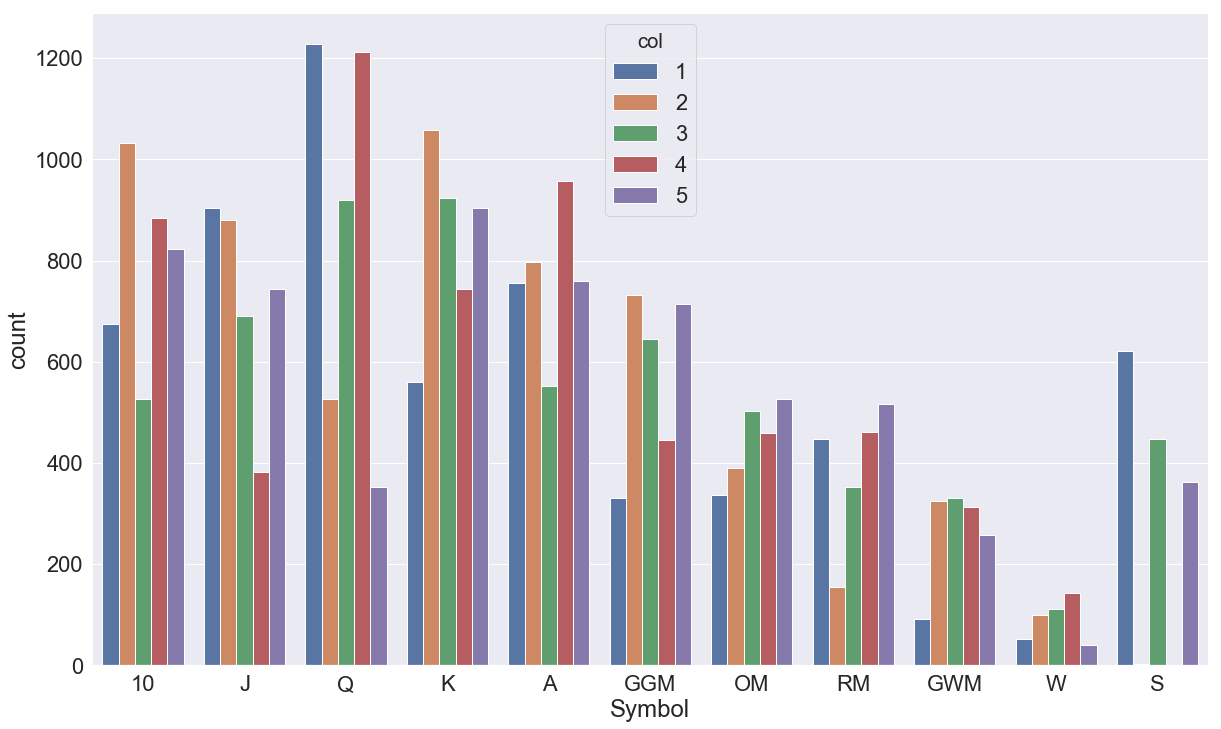

In [134]:
# 각 reel별 출현 횟수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='classname', data=ms_slot_result, hue='col', order=ms_labels)
plt.xlabel("Symbol")
plt.show()

In [173]:
'''
# Baseline Model

Monster Slot 2000번의 실제 게임 데이터를 기반으로 각 Symbol의 출현 빈도 설정 (근사치)

# Q   : 14 %
# K   : 14 %
# 10  : 13 %
# A   : 12.5 %
# J   : 12 %
# GGM : 9.5 %
# OM  : 7.5 %
# RM  : 6.5 %
# S   : 5 %
# GWM : 4.5 %
# W   : 1.5 %
'''

# numpy의 randint를 통해 출현 확률을 기반으로 Symbol을 Return하는 함수

def getMonsterSymbol(start, end):
    i = np.random.randint(start, end)
    if i <= 28:
        return 'Q'
    elif i <= 56 and i > 28:
        return 'K'
    elif i <= 82 and i > 56:
        return '10'
    elif i <= 107 and i > 82:
        return 'A'
    elif i <= 131 and i > 107:
        return 'J'
    elif i <= 150 and i > 131:
        return 'GGM'
    elif i <= 165 and i > 150:
        return 'OM'
    elif i <= 178 and i > 165:
        return 'RM'
    elif i <= 187 and i > 178:
        return 'GWM'
    elif i <= 190 and i > 187:
        return 'W'
    elif i > 190:
        return 'S'

# 1회의 Spin 실행을 구현한 함수

def spin_monster():
    game = []
    start = 1
    
    for i in range(15):
        # 각 15개의 칸에 Symbol 추가
        if i%6 <= 2 and game.count('S') < ((i//6) + 1):
            end = 201
            game.append(getMonsterSymbol(start, end))
        else:
            end = 191
            game.append(getMonsterSymbol(start, end))

    return game

In [174]:
# 실행 결과를 담을 list
ms_simul_result_per_game = []

# 2000번의 게임을 실행
for i in range(2000):
    ms_simul_result_per_game.append(spin_monster())

In [175]:
# 실제 게임 플레이 DataFrame을 불러와서 가상 게임플레이 데이터로 변경

ms_simul_result = ms_slot_result[['classname', 'game', 'row', 'col']]

ms_simul_classname = []

for game in ms_simul_result_per_game:
    for x in game:
        ms_simul_classname.append(x)

ms_simul_result['classname'] = ms_simul_classname

C:\Users\Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [176]:
ms_simul_result.head()

,classname,game,row,col
0,K,0,1,1
1,Q,0,2,1
2,Q,0,3,1
3,A,0,1,2
4,GGM,0,2,2


## 비교 - Scatter

In [206]:
# 실제 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

ms_real_scatter_count =  []
for game in ms_slot_result_per_game:
    ms_real_scatter_count.append(game.count('S'))

# 실제 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(ms_real_scatter_count).value_counts()

0    865
1    862
2    245
3     28
dtype: int64

In [207]:
# 가상 게임의 게임당 SCATTER 출현 횟수를 담은 list를 생성

ms_simul_scatter_count = []
for game in ms_simul_result_per_game:
    ms_simul_scatter_count.append(game.count('S'))

# 가상 게임의 Spin당 RICHHITS의 출현 갯수

pd.Series(ms_simul_scatter_count).value_counts()

0    1250
1     619
2     117
3      14
dtype: int64

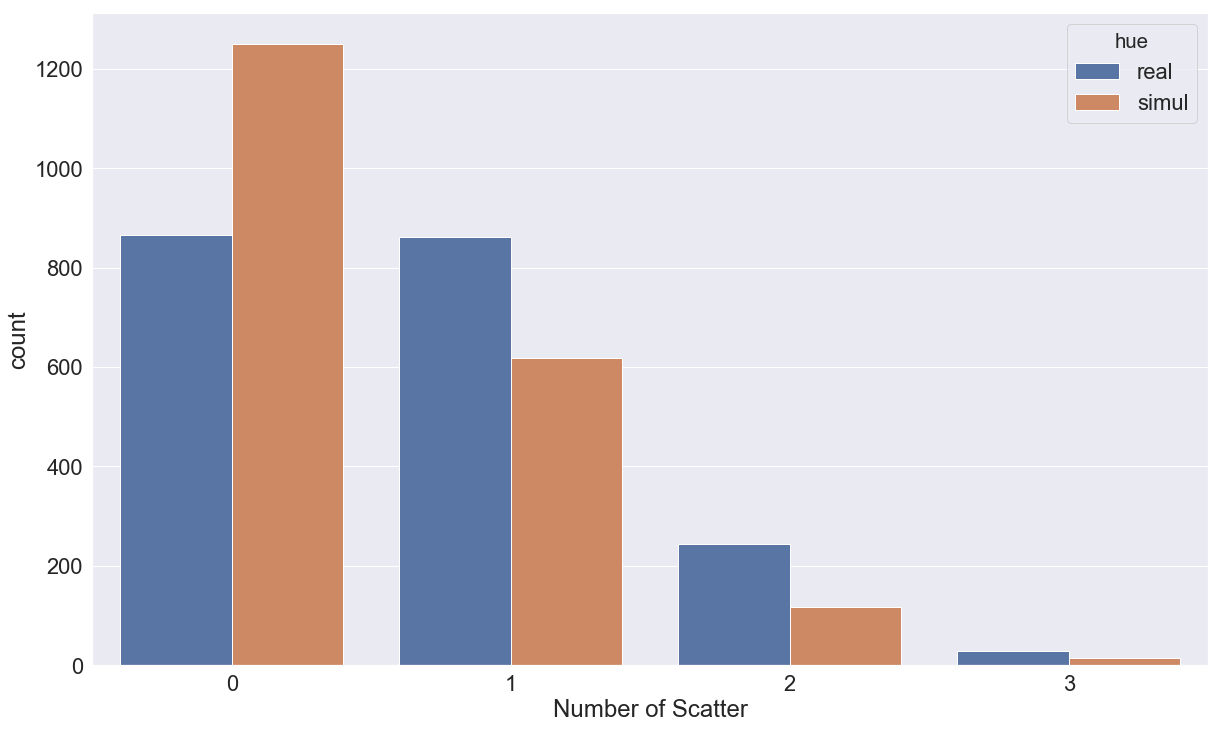

In [179]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_ms_scatter = pd.DataFrame(columns=['scatter_count', 'hue'])
df_ms_scatter['scatter_count'] = ms_real_scatter_count + ms_simul_scatter_count
df_ms_scatter['hue'] = ['real'] * 2000 + ['simul'] * 2000

# 실제, 가상의 각 게임당 RICHHITS 갯수 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='scatter_count', data=df_ms_scatter, hue='hue')
plt.xlabel("Number of Scatter")
plt.show()

## 비교 - ReelType

In [201]:
def getReelInfo(df, reel):
    row_type = []
    reel_symbols = []
    r_list = []
    s = ''
    for n, row in enumerate(df[df['col'] == reel]['classname']):
        r_list.append(row)
        s += row
        if not (n + 1) % 3:
            if r_list[0] == r_list [1] and r_list[1] == r_list[2]:
                row_type.append('1')
            elif r_list[0] == r_list[1] and r_list[0] != r_list[2] and r_list[1] != r_list[2]:
                row_type.append('2-1')
            elif r_list[0] == r_list[2] and r_list[0] != r_list[1] and r_list[2] != r_list[1]:
                row_type.append('2-2')
            elif r_list[1] == r_list[2] and r_list[1] != r_list[0] and r_list[2] != r_list[0]:
                row_type.append('2-3')
            else:
                row_type.append('3')
            r_list = []
            reel_symbols.append(s)
            s= ''
    return row_type, reel_symbols

In [202]:
# 실제 게임의 각 reel의 유형, symbol 저장

ms_real_reel1_rtype, ms_real_reel1_rsymbols = getReelInfo(ms_slot_result, 1)
ms_real_reel2_rtype, ms_real_reel2_rsymbols = getReelInfo(ms_slot_result, 2)
ms_real_reel3_rtype, ms_real_reel3_rsymbols = getReelInfo(ms_slot_result, 3)
ms_real_reel4_rtype, ms_real_reel4_rsymbols = getReelInfo(ms_slot_result, 4)
ms_real_reel5_rtype, ms_real_reel5_rsymbols = getReelInfo(ms_slot_result, 5)

ms_real_reel_rtype = ms_real_reel1_rtype + ms_real_reel2_rtype + ms_real_reel3_rtype + ms_real_reel4_rtype + ms_real_reel5_rtype 

In [203]:
# 가상 게임의 각 reel의 유형, symbol 저장

ms_simul_reel1_rtype, ms_simul_reel1_rsymbols = getReelInfo(ms_simul_result, 1)
ms_simul_reel2_rtype, ms_simul_reel2_rsymbols = getReelInfo(ms_simul_result, 2)
ms_simul_reel3_rtype, ms_simul_reel3_rsymbols = getReelInfo(ms_simul_result, 3)
ms_simul_reel4_rtype, ms_simul_reel4_rsymbols = getReelInfo(ms_simul_result, 4)
ms_simul_reel5_rtype, ms_simul_reel5_rsymbols = getReelInfo(ms_simul_result, 5)

ms_simul_reel_rtype = ms_simul_reel1_rtype + ms_simul_reel2_rtype + ms_simul_reel3_rtype + ms_simul_reel4_rtype + ms_simul_reel5_rtype

In [204]:
# 비교를 위해 실제 게임 데이터의 reel_type을 담을 DataFrame을 생성

df_ms_rtype = pd.DataFrame(columns=['reel_type', 'reel_num', 'game_type'])
df_ms_rtype['reel_type'] = ms_real_reel_rtype + ms_simul_reel_rtype
df_ms_rtype['reel_num'] = (['reel_1'] * 2000 + ['reel_2'] * 2000 + ['reel_3'] * 2000 + ['reel_4'] * 2000 + ['reel_5'] * 2000) * 2
df_ms_rtype['game_type'] = ['real'] * 10000 + ['simul'] * 10000

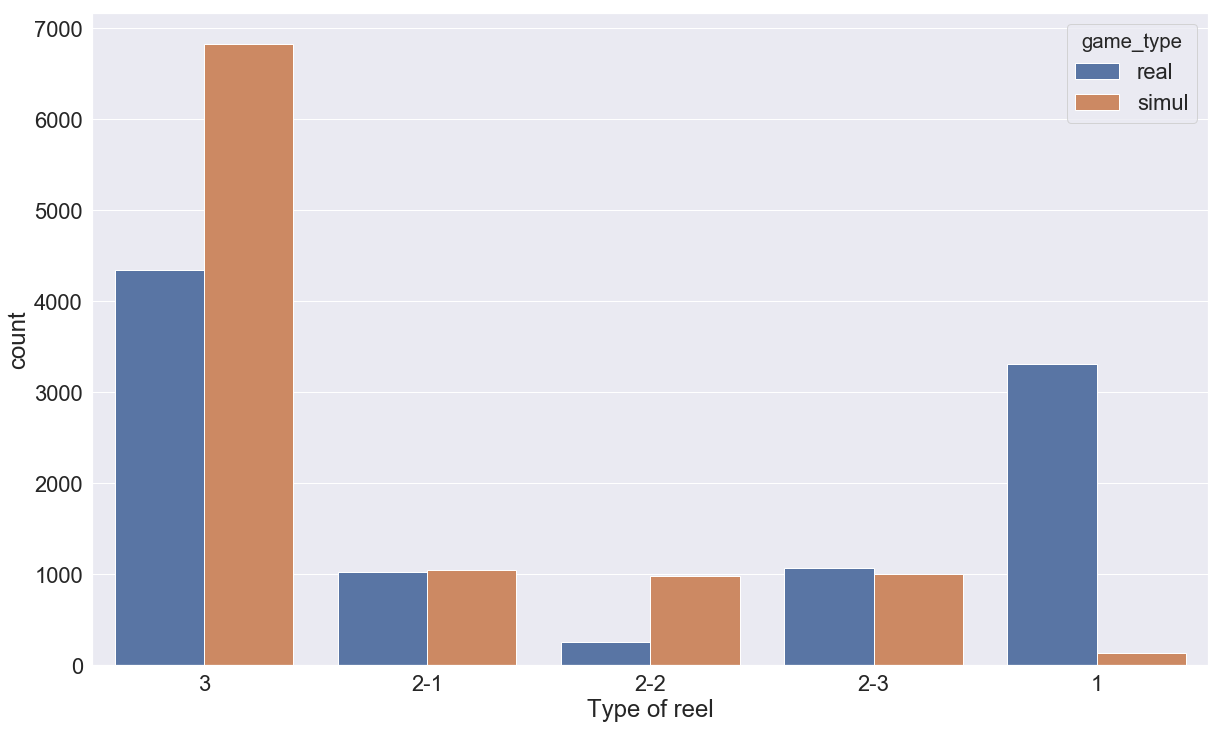

In [205]:
# 모든 reel의 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_ms_rtype, order=['3', '2-1', '2-2', '2-3', '1'], hue='game_type')
plt.xlabel("Type of reel")
plt.show()

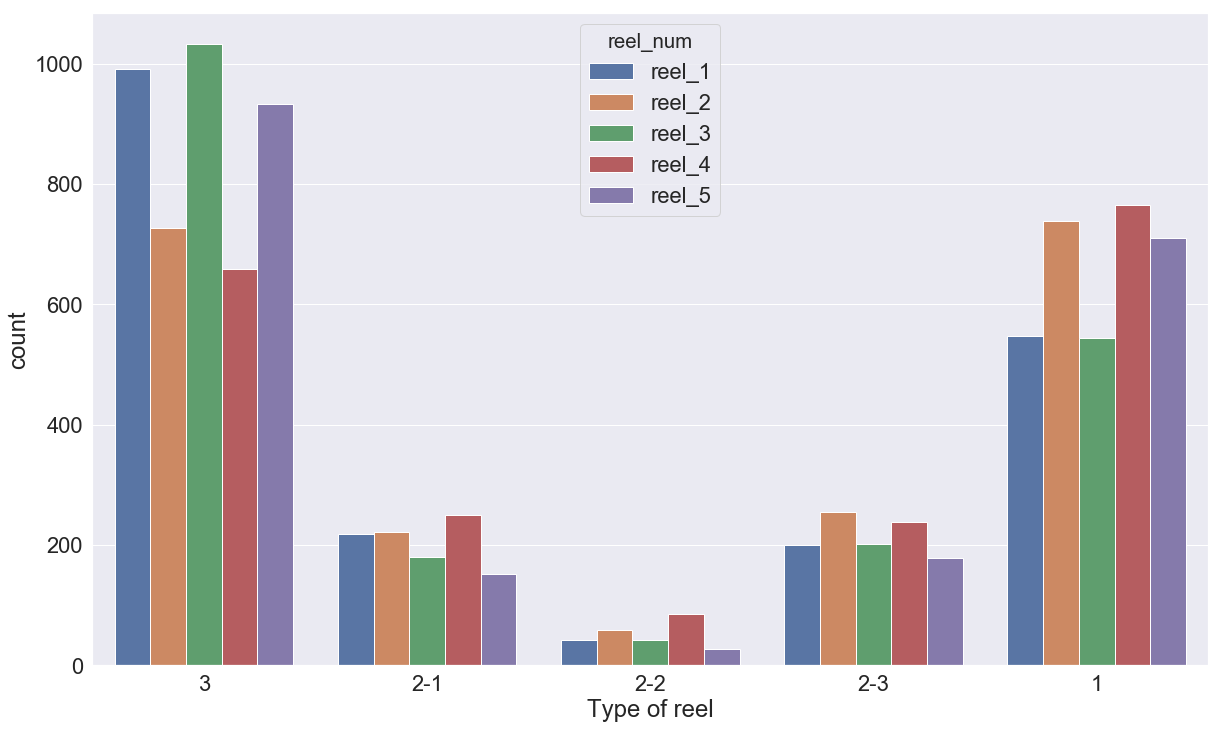

In [189]:
# 각 reel_num 별 reel_type 시각화

plt.figure(figsize=(20,12))
sns.countplot(x='reel_type', data=df_ms_rtype[df_ms_rtype['game_type']=='real'], hue='reel_num', order=['3', '2-1', '2-2', '2-3', '1'])
plt.xlabel("Type of reel")
plt.show()

In [191]:
# 실제 게임의 게임당 unique symbol의 개수를 담은 list를 생성

ms_real_unique_count = []

for i in range(2000):
    ms_real_unique_count.append(len(set(ms_slot_result_per_game[i])))

In [192]:
# 가상 게임의 게임당 unique symbol의 개수를 담은 list를 생성

ms_simul_unique_count = []

for i in range(2000):
    ms_simul_unique_count.append(len(set(ms_simul_result_per_game[i])))

In [198]:
df_ms_real_simul = pd.DataFrame(columns=['classname', 'game_type'])
df_ms_real_simul['classname'] = pd.concat([ms_slot_result['classname'], ms_simul_result['classname']])
df_ms_real_simul['game_type'] = ['real'] * len(ms_slot_result['classname']) + ['simul'] * len(ms_simul_result['classname'])
df_ms_real_simul = ms_real_simul_df.reset_index(drop=True)

In [197]:
# 비교를 위해 실제, 가상 결과를 담을 DataFrame을 생성

df_ms_unique_count = pd.DataFrame(columns=['unique_count', 'game_type'])
df_ms_unique_count['unique_count'] = ms_real_unique_count + ms_simul_unique_count
df_ms_unique_count['game_type'] = ['real'] * len(ms_real_unique_count) + ['simul'] * len(ms_simul_unique_count)

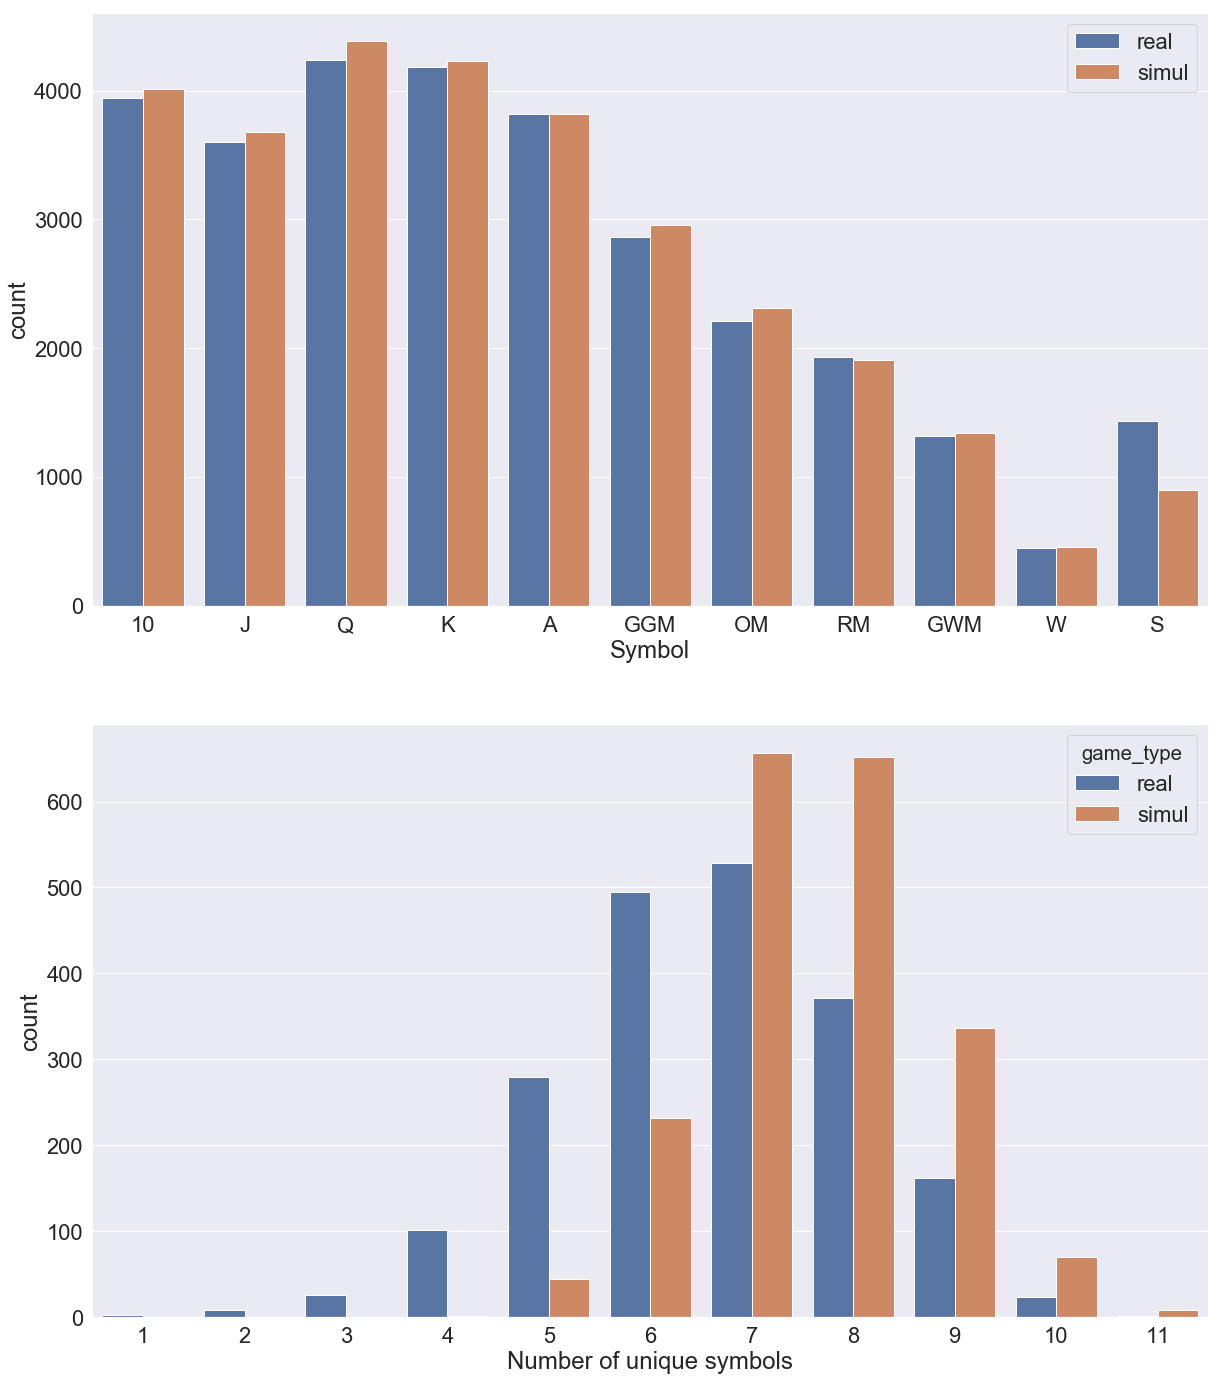

In [200]:
plt.figure(figsize=(20,24))
plt.subplot(2,1,1)
sns.countplot(x='classname', data=df_ms_real_simul, hue='game_type', order=ms_labels)
plt.xlabel('Symbol')

plt.legend()
plt.subplot(2,1,2)
sns.countplot(x='unique_count', data=df_ms_unique_count, hue='game_type')
plt.xlabel('Number of unique symbols')
plt.show()